# Import modules

In [1]:
#import general modules
import numpy as np
import io, sys, time, math, os.path, unittest, sys
import matplotlib.pyplot as plt
import pandas as pd

# Load files

In [3]:
#Todo: use sys commands to dynamically find in github folder
github_folder='/Users/alextaipale/Projects/BayesHack/greenspace/'
file_location=github_folder+'raw_data/'

file_name='NRRS_reservations_byVisitorOriginZip_AllYears.csv'
zip_origin_df=pd.read_csv(file_location+file_name)

file_name='NRRS_reservations_byFacilityName_AllYears.csv'
by_campground_df=pd.read_csv(file_location+file_name)

file_name='PPL_reservationdata.csv' #2.2gb --> very large
reservation_df=by_campground_df=pd.read_csv(file_location+file_name)


In [4]:
#load models
github_folder='/Users/alextaipale/Projects/BayesHack/greenspace/'
file_location=github_folder+'raw_data/'
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
#distance_to_park_df[['D2NF_km','ZIP_CODE']]

In [5]:
#Census Data
file_location=github_folder+'raw_data/'

file_name='aggregate_income.csv'
income_df=pd.read_csv(file_location+file_name)

file_name='2010CensusPopulationData.csv'
racial_info_df=pd.read_csv(file_location+file_name)

#distance to 
file_name='ESRI_ZipCodes_wDistance2nearestFacility_km.txt'
distance_to_park_df=pd.read_csv(file_location+file_name)
distance_to_park_df[['D2NF_km','ZIP_CODE']]

file_name='education.csv'
education_df=pd.read_csv(file_location+file_name)
education_df.rename(columns={'zip code tabulation area': 'zip_code_tabulation_area'},inplace=True)
education_df.rename(columns={'B06009_001E': 'Total_reported_education_per_zip'},inplace=True)
education_df.rename(columns={'B06009_002E': 'Less_than_high_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_003E': 'High_school_graduate'},inplace=True)
education_df.rename(columns={'B06009_004E': 'Some_college_or_associates_degree'},inplace=True)
education_df.rename(columns={'B06009_005E': 'Bachelor_degree'},inplace=True)
education_df.rename(columns={'B06009_006E': 'Graduate_or_professional_degree'},inplace=True)
education_df=education_df[['zip_code_tabulation_area','Less_than_high_school_graduate','High_school_graduate'
                ,'Some_college_or_associates_degree','Bachelor_degree','Graduate_or_professional_degree'
                ,'Total_reported_education_per_zip']]
#education_df

In [16]:
temp=reservation_df.drop_duplicates(subset = ' CustZip')
temp=temp[[' CustState',' CustCountry',' CustZip']]
temp[' CustZip']=temp[' CustZip'].convert_objects(convert_numeric=True)

# Join dataframes

In [17]:
#join the dataframes
aggregate_df=pd.merge(zip_origin_df, racial_info_df, left_on = 'visitor_zip', right_on = 'Zip')
aggregate_df=pd.merge(aggregate_df,income_df,left_on='visitor_zip',right_on='zip code tabulation area')
#move the line below to higher up
aggregate_df.rename(columns={'Annual Aggregate Family Income': 'Annual_Aggregate_Family_Income'},inplace=True)
aggregate_df= pd.merge(aggregate_df,temp,left_on = 'visitor_zip', right_on = ' CustZip')
aggregate_df= pd.merge(aggregate_df,education_df,left_on='visitor_zip',right_on='zip_code_tabulation_area')
aggregate_df=pd.merge(aggregate_df,distance_to_park_df,left_on='visitor_zip',right_on='ZIP_CODE')

In [18]:
#rename columns without spaces
aggregate_df.rename(columns={' CustZip': 'CustZip'},inplace=True)
aggregate_df.rename(columns={' CustState': 'CustState'},inplace=True)
aggregate_df.rename(columns={' CustCountry': 'Custcountry'},inplace=True)
#aggregate_df.iloc[0]['Custcountry']

# Create new columns

In [19]:
#get the utilization_factors into the dataframe
aggregate_df['util_unique'] = pd.Series(
    (aggregate_df.sum_dur / aggregate_df.Population))
aggregate_df['util_days']= pd.Series(
    (aggregate_df.sum_persnight  / aggregate_df.Population))

In [20]:
aggregate_df

,visitor_zip,visitorzip_lat,visitorzip_lon,qpartysize25,qpartysize50,qpartysize75,qleadt25,qleadt50,qleadt75,qdur25,...,Last_SiteT,First_FacZ,First_Park,Min_ParkLo,Max_ParkLo,ParkLat,Distance,D2NF_km,util_unique,util_days
0,601,18.196747,-66.736735,1.75,2,2,0.00,0.0,0.2,1.8,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1648698.352008,1648.698352,0.000754,0.001454
1,602,18.352927,-67.177532,2,2,2.25,60.50,84.0,89.0,2.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1594130.020035,1594.130020,0.000265,0.000602
2,603,18.458585,-67.129867,3,3,3,26.00,26.0,26.0,1.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1593693.042584,1593.693043,0.000018,0.000055
3,612,18.388009,-66.665279,2,2,2,3.00,14.0,25.0,2.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1631755.053617,1631.755054,0.000075,0.000149
4,627,18.425195,-66.867756,1,1,1,6.00,6.0,6.0,2.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1618844.919164,1618.844919,0.000057,0.000057
5,631,18.224554,-66.867756,4,4,4,181.00,181.0,181.0,3.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1632726.143526,1632.726144,0.001620,0.006479
6,646,18.459098,-66.272418,2,4,5,20.25,27.0,79.0,1.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1672798.725772,1672.798726,0.000209,0.000864
7,660,18.138245,-67.111993,1.25,2,2.75,7.50,30.0,30.0,2.2,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1613893.202817,1613.893203,0.000464,0.000870
8,662,18.456130,-67.022630,2,2,2,40.00,40.0,40.0,2.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1601840.715362,1601.840715,0.000046,0.000092
9,664,18.210309,-66.581923,6,6,6,0.00,0.0,0.0,2.0,...,WALK TO,NaN,25.138611,-80.941667,-80.941667,25.138611,1657138.915133,1657.138915,0.000119,0.000715


In [21]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['sum_dur']\
    /float(aggregate_df.iloc[[0]]['Population'])),\
     float(aggregate_df.iloc[[0]]['util_unique']))

This 0.000754 should equal that 0.000754


In [22]:
#get the male/female breakdowns per visit per zip code
#using unique visits for the rest of these breakdowns!! (i.e. sum_dur)
aggregate_df['visits_female'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))
aggregate_df['visits_male'] = pd.Series(
    ((aggregate_df.PopulationFemale / aggregate_df.Population)*aggregate_df.sum_dur))

In [23]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationFemale']\
    /float(aggregate_df.iloc[[0]]['Population']))\
    *float(aggregate_df.iloc[[0]]['sum_dur']),\
     float(aggregate_df.iloc[[0]]['visits_female']))

This 7.156058 should equal that 7.156058


In [24]:
#get the race breakdown per visit per zip code
aggregate_df['visits_RaceWhite'] = pd.Series(
    (aggregate_df.PopulationRaceWhite * aggregate_df.sum_dur))
aggregate_df['visits_RaceBlack'] = pd.Series(
    (aggregate_df.PopulationRaceBlack * aggregate_df.sum_dur))
aggregate_df['visits_Amerindian'] = pd.Series(
    (aggregate_df.PopulationAmerindian * aggregate_df.sum_dur))
aggregate_df['visits_RacePacific'] = pd.Series(
    (aggregate_df.PopulationRacePacific * aggregate_df.sum_dur))
aggregate_df['visits_RaceLatino'] = pd.Series(
    (aggregate_df.PopulationRaceLatino * aggregate_df.sum_dur))
aggregate_df['visits_RaceMulti'] = pd.Series(
    (aggregate_df.PopulationRaceMulti * aggregate_df.sum_dur))
aggregate_df['visits_RaceOther'] = pd.Series(
    (aggregate_df.PopulationRaceOther * aggregate_df.sum_dur))

In [25]:
'''
TODO
make a unittest to make sure this is joined correctly
'''
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['PopulationRaceWhite']\
    *float(aggregate_df.iloc[[0]]['sum_dur'])),\
     float(aggregate_df.iloc[[0]]['visits_RaceWhite']))

This 0.060312 should equal that 0.060312


In [26]:
#scale the annual family aggregate income (which is per zip code)
#to individual families
aggregate_df['per_family_annual_income'] = pd.Series(
    (aggregate_df.Annual_Aggregate_Family_Income / aggregate_df.Households))

In [27]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[0]]['Annual_Aggregate_Family_Income']\
    /float(aggregate_df.iloc[[0]]['Households'])),\
     float(aggregate_df.iloc[[0]]['per_family_annual_income']))


This 16366.160920 should equal that 16366.160920


In [28]:
#get percent of people who are high school educated
aggregate_df['non_hs_educated'] = pd.Series(
    (aggregate_df.Less_than_high_school_graduate / aggregate_df.Total_reported_education_per_zip))

In [29]:
print 'This %f should equal that %f'%\
    (float(aggregate_df.iloc[[-1]]['Less_than_high_school_graduate']\
    /float(aggregate_df.iloc[[-1]]['Total_reported_education_per_zip'])),\
     float(aggregate_df.iloc[[-1]]['non_hs_educated']))

This 0.109489 should equal that 0.109489


# Trim data

In [30]:
#create the data to send to Cartos DB and use for the graphing
regression_df=aggregate_df[[
        'CustZip',
        'CustState',
        'per_family_annual_income',
        'non_hs_educated',
        'PopulationRaceWhite',
        'D2NF_km',
        'util_days']]
#rename the distance column
regression_df.rename(columns={'D2NF_km': 'Dist_to_park'},inplace=True)
#print random entry
regression_df.iloc[81]

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2518: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


CustZip                           1037
CustState                           MA
per_family_annual_income         77550
non_hs_educated             0.04565217
PopulationRaceWhite          0.9582339
Dist_to_park                  32.42492
util_days                   0.08591885
Name: 81, dtype: object

# Save the trimmed datframe to database

In [34]:
#save the dataframe to a csv
file_location=github_folder + 'processed_data/'
file_name='test4.csv'
regression_df.to_csv(file_location+file_name, sep=',')

# Plot correlations

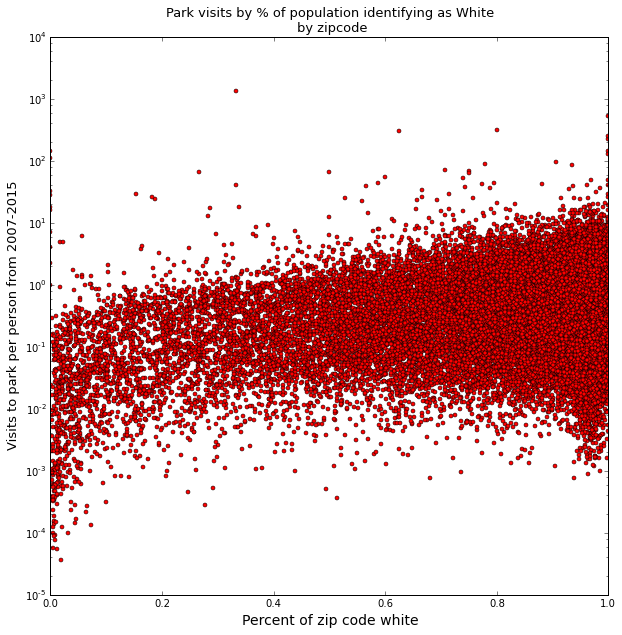

In [35]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['PopulationRaceWhite'],regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Percent of zip code white',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

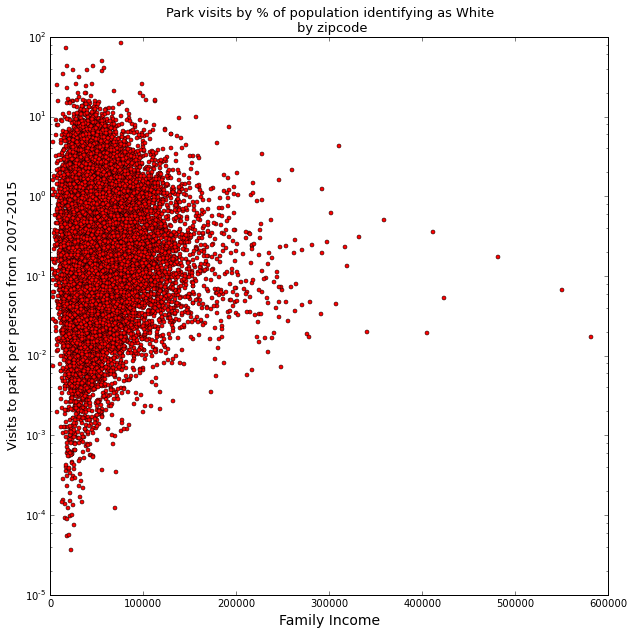

In [36]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.semilogy(regression_df['per_family_annual_income'],\
             regression_df['util_days'],'ro',markersize = 4)
plt.xlabel('Family Income',size=14)
plt.ylabel('Visits to park per person from 2007-2015', size=13)
plt.title('Park visits by % of population identifying as White \n by zipcode', size=13)

In [46]:
data_cleaned=regression_df['util_days'].replace([np.inf, -np.inf], np.nan).dropna()
#DROP THE NAN AND INFINITE DATA
print len(data_cleaned)
print len(data_cleaned)
data_cleaned.tolist()
data_cleaned_hist=[]
'''
for i in data_cleaned:
    if data_cleaned[i] >= 0 and  data_cleaned[i] < 100000:
        data_cleaned_hist.append(float(data_cleaned[i]))
print len(data_cleaned_hist)
'''

31769
31769


'\nfor i in data_cleaned:\n    if data_cleaned[i] >= 0 and  data_cleaned[i] < 100000:\n        data_cleaned_hist.append(float(data_cleaned[i]))\nprint len(data_cleaned_hist)\n'

In [71]:
np.array(data_cleaned)



array([  1.45395800e-03,   6.02119461e-04,   5.48556382e-05, ...,
         1.31013431e+00,   2.23287671e-01,   6.21556886e+00])

In [58]:
data_cleaned.describe()



count    31769.000000
mean         0.971729
std          9.133614
min          0.000000
25%          0.093004
50%          0.275026
75%          0.874541
max       1356.666667
Name: util_days, dtype: float64

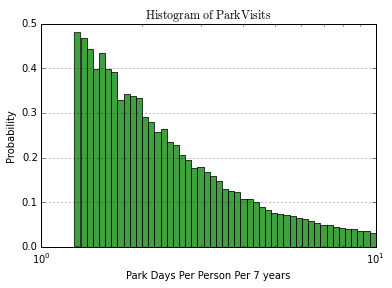

In [79]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
'''
#TODO MAKE A HISTOGRAM of the data_cleaned
'''
#exampleeeeee
mu, sigma = 0.97172898269558805, 9.1336139360159088
x =mu+ sigma*np.array(data_cleaned)




n, bins, patches = plt.hist(x, bins=np.logspace(0.1, 1.0, 50), normed=1, facecolor='green', alpha=0.75)

plt.gca().set_xscale("log")
plt.grid(True)
plt.xlabel('Park Days Per Person Per 7 years')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Park Visits}$')
plt.grid(True)

plt.show()
